In [1]:
import time

In [2]:
start = time.perf_counter()

import torch

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

Elapsed time: 50.034759 seconds


In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from timeit import timeit
from tqdm import tqdm

In [5]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA not available. Please ensure your PyTorch installation supports GPU.")

In [6]:
sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096]

In [10]:
def dummy():
    time.sleep(1)

In [11]:
timeit(dummy, number=3)

3.000271494999879

In [19]:
if torch.cuda.is_available():
    _device = 'cuda'
elif torch.backends.mps.is_available():
    _device = 'mps'
else:
    _device = 'cpu'

_device

'cuda'

In [20]:
device = torch.device(_device)
device

device(type='cuda')

In [48]:
def print_tensor_memory(x):
    # element_size() gives bytes per element
    memory_bytes = x.element_size() * x.nelement()
    print(f"Memory usage: {memory_bytes / 1024 / 1024:.2f} MB")

In [58]:
def warm_gpu():
    '''
    Warm up the GPU to ensure it's at full clock speed.
    Modern GPUs use dynamic frequency scaling (similar to CPU turbo boost) to save power.
    When idle, they run at lower clock speeds. The first operation might run slower because
    the GPU needs to "wake up" and ramp up to full speed. This is called "cold start" latency.
    '''
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    for _ in range(10):
        _size = 10_000
        _a = torch.randn(_size, _size, device=device)
        _b = torch.randn(_size, _size).to(device)
        _ = _a @ _b
        torch.cuda.synchronize()
        torch.cuda.empty_cache()
    end.record()

    elapsed_time_ms = start.elapsed_time(end)
    print(f'warming up the GPU took {elapsed_time_ms/1_000:.03f}s')

In [59]:
warm_gpu()

warming up the GPU took 6.351s


# Benchmarking Tensor Creation on CPU

In [66]:
# Warm up the GPU to ensure it's at full clock speed.
warm_gpu()

# Multiple runs for more stable measurements.
n_runs = 10
times = []
_size = 10_000

for _ in tqdm(range(n_runs), desc=f'Size {_size}x{_size}'):
    start = time.perf_counter()
    _ = torch.randn(_size, _size)
    end = time.perf_counter()
    
    times.append(end - start)

avg_time = sum(times) / len(times)
std_time = (sum((t - avg_time) ** 2 for t in times) / len(times)) ** 0.5

print(f'Average time over {n_runs} runs: {avg_time:.3f}ms ± {std_time:.3f}ms')

warming up the GPU took 6.330s


Size 10000x10000: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.78it/s]

Average time over 10 runs: 0.541ms ± 0.001ms


In [75]:
def benchmark_tensor_creation(size, n_runs=10):
    times = []
    
    for _ in tqdm(range(n_runs), desc=f'Size {size}x{size}'):
        start = time.perf_counter()
        _ = torch.randn(size, size)
        end = time.perf_counter()
        times.append((end - start) * 1000)  # Convert to ms
    
    avg_time = sum(times) / len(times)
    std_time = (sum((t - avg_time) ** 2 for t in times) / len(times)) ** 0.5
    
    return pd.DataFrame({
        'size': [size],
        'avg_time_ms': [avg_time],
        'std_time_ms': [std_time]
    })

In [76]:
# Test different size matrices.
sizes = [1_000, 5_000, 10_000, 15_000, 20_000, 30_000]
results = pd.concat([benchmark_tensor_creation(size) for size in sizes])

Size 30000x30000: 100%|█████████████████████████████████████████████████████████████████████████| 10/10 [00:50<00:00,  5.02s/it]


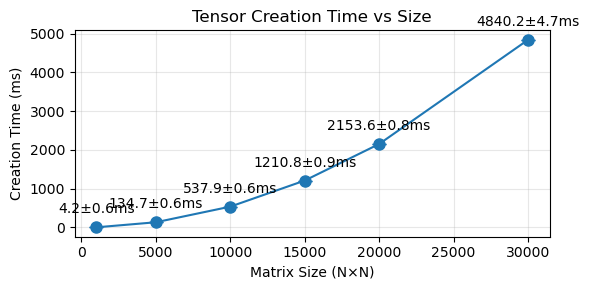

Detailed Results:


,size,avg_time_ms,std_time_ms
0,1000,4.218414,0.586573
1,5000,134.724479,0.586300
2,10000,537.909891,0.585343
3,15000,1210.831102,0.859623
4,20000,2153.627870,0.825242
5,30000,4840.159727,4.740422


In [81]:
# Make the plot
plt.figure(figsize=(6, 3))

plt.errorbar(
    results['size'], 
    results['avg_time_ms'],
    yerr=results['std_time_ms'],
    fmt='o-',  # Points connected by lines
    capsize=5,  # Length of the error bar caps
    capthick=1,
    elinewidth=1,
    markersize=8
)

plt.xlabel('Matrix Size (N×N)')
plt.ylabel('Creation Time (ms)')
plt.title('Tensor Creation Time vs Size')
plt.grid(True, alpha=0.3)

# Add exact values above each point
for idx, row in results.iterrows():
    plt.annotate(
        f'{row["avg_time_ms"]:.1f}±{row["std_time_ms"]:.1f}ms',
        (row['size'], row['avg_time_ms']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

plt.tight_layout()
plt.show()

# Print the numeric results too
print("Detailed Results:")

results = results.reset_index(drop=True)
results

In [80]:
results['avg_time_ms'].iloc[0]

4.218413500166207

In [86]:
for idx in range(1, len(results)):
    baseline = results['avg_time_ms'].iloc[0]
    comparison = results['avg_time_ms'].iloc[idx]
    ratio = comparison / baseline
    comparison_size = results['size'].iloc[idx]
    
    print(f'run of size {comparison_size:_} was {ratio:.03f}x slower than the baseline')

run of size 5_000 was 31.937x slower than the baseline
run of size 10_000 was 127.515x slower than the baseline
run of size 15_000 was 287.035x slower than the baseline
run of size 20_000 was 510.530x slower than the baseline
run of size 30_000 was 1147.389x slower than the baseline


In [89]:
# Add columns for total elements and time per element.
results['total_elements'] = results['size'] ** 2
results['time_per_element_ns'] = (results['avg_time_ms'] * 1e6) / results['total_elements']  # Convert to nanoseconds

# Create comparison metrics.
baseline_size = results['size'].iloc[0]
baseline_time = results['avg_time_ms'].iloc[0]
baseline_elements = results['total_elements'].iloc[0]
baseline_time_per_element = results['time_per_element_ns'].iloc[0]

comparisons = pd.DataFrame({
    'size': results['size'],
    'total_elements': results['total_elements'],
    'absolute_time_ratio': results['avg_time_ms'] / baseline_time,
    'elements_ratio': results['total_elements'] / baseline_elements,
    'time_per_element_ratio': results['time_per_element_ns'] / baseline_time_per_element
})

In [99]:
comparisons.round(3)

,size,total_elements,absolute_time_ratio,elements_ratio,time_per_element_ratio
0,1000,1000000,1.000,1.0,1.000
1,5000,25000000,31.937,25.0,1.277
2,10000,100000000,127.515,100.0,1.275
3,15000,225000000,287.035,225.0,1.276
4,20000,400000000,510.530,400.0,1.276
5,30000,900000000,1147.389,900.0,1.275


In [96]:
print(f"Baseline: {baseline_size:_}x{baseline_size:_} matrix")
print("\nComparisons:")
for idx, row in comparisons.iloc[1:].iterrows():
    print(f"\nMatrix size: {row['size']:_}x{row['size']:_}")
    print(f"- Total elements: {row['total_elements']:_} ({row['elements_ratio']:.1f}x more than baseline)")
    print(f"- Absolute time: {row['absolute_time_ratio']:.2f}x slower than baseline")
    print(f"- Time per element: {row['time_per_element_ratio']:.2f}x {'slower' if row['time_per_element_ratio'] > 1 else 'faster'} than baseline")

Baseline: 1_000x1_000 matrix

Comparisons:

Matrix size: 5_000.0x5_000.0
- Total elements: 25_000_000.0 (25.0x more than baseline)
- Absolute time: 31.94x slower than baseline
- Time per element: 1.28x slower than baseline

Matrix size: 10_000.0x10_000.0
- Total elements: 100_000_000.0 (100.0x more than baseline)
- Absolute time: 127.51x slower than baseline
- Time per element: 1.28x slower than baseline

Matrix size: 15_000.0x15_000.0
- Total elements: 225_000_000.0 (225.0x more than baseline)
- Absolute time: 287.03x slower than baseline
- Time per element: 1.28x slower than baseline

Matrix size: 20_000.0x20_000.0
- Total elements: 400_000_000.0 (400.0x more than baseline)
- Absolute time: 510.53x slower than baseline
- Time per element: 1.28x slower than baseline

Matrix size: 30_000.0x30_000.0
- Total elements: 900_000_000.0 (900.0x more than baseline)
- Absolute time: 1147.39x slower than baseline
- Time per element: 1.27x slower than baseline


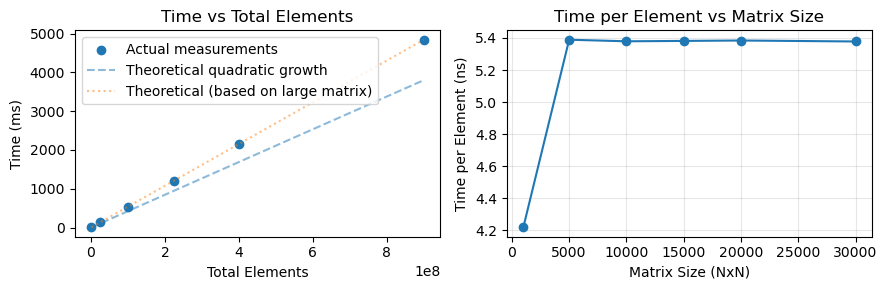

In [110]:
# Visualize the relationships.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Plot 1: Time vs Elements with theoretical quadratic growth.
x = results['total_elements']
y = results['avg_time_ms']
ax1.scatter(x, y, label='Actual measurements')
ax1.set_xlabel('Total Elements')
ax1.set_ylabel('Time (ms)')

# Add theoretical quadratic growth line.
theoretical_quad = (x/x.iloc[0]) * y.iloc[0]  # If growth was perfectly quadratic.
ax1.plot(x, theoretical_quad, '--', label='Theoretical quadratic growth', alpha=0.5)

# New theoretical line based on larger matrix timing
large_matrix_time_per_element = results['time_per_element_ns'].iloc[-1] * 1e-6  # convert back to ms
theoretical_large = x * large_matrix_time_per_element
ax1.plot(x, theoretical_large, ':', label='Theoretical (based on large matrix)', alpha=0.5)

ax1.legend(loc='best')
ax1.set_title('Time vs Total Elements')

# Plot 2: Time per element.
ax2.plot(results['size'], results['time_per_element_ns'], 'o-')
ax2.set_xlabel('Matrix Size (NxN)')
ax2.set_ylabel('Time per Element (ns)')
ax2.set_title('Time per Element vs Matrix Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The dashed blue line shows theoretical quadratic growth (what you'd expect if doubling elements exactly doubled the time).
This suggests there's some additional overhead as matrices get bigger.

Right graph suggests two "regimes" of performance:

1. Small matrices (<5000x5000): ~4.2ns per element
1. Large matrices (≥5000x5000): ~5.4ns per element

After hitting this threshold, the operation becomes about 28% slower per element (from 4.2ns to 5.4ns).
This pattern often suggests memory/cache effects:

1. Smaller matrices might fit entirely in CPU cache
1. Larger matrices exceed cache size, forcing slower memory access
1. Once you're in "out of cache" territory, the performance per element stabilizes

In [104]:
_dummy = torch.randn(1_000, 1_000)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 3.81 MB


In [114]:
_dummy = torch.randn(5_000, 5_000)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 95.37 MB


In [105]:
_dummy = torch.randn(10_000, 10_000)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 381.47 MB


In [130]:
!head -n 30 /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 25
model		: 1
model name	: AMD EPYC 7R13 Processor
stepping	: 1
microcode	: 0xa0011d5
cpu MHz		: 3244.941
cache size	: 512 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 16
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch topoext ssbd ibrs ibpb stibp vmmcall fsgsbase bmi1 avx2 smep bmi2 invpcid rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr rdpru wbnoinvd arat npt nrip_save vaes vpclmulqdq rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 sp

In [112]:
!lscpu | grep "cache"

L1d cache:                            64 KiB (2 instances)
L1i cache:                            64 KiB (2 instances)
L2 cache:                             1 MiB (2 instances)
L3 cache:                             8 MiB (1 instance)


In [115]:
_dummy = torch.randn(1_000, 1_000)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 3.81 MB


In [117]:
_dummy = torch.randn(1_200, 1_200)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 5.49 MB


In [118]:
_dummy = torch.randn(1_400, 1_400)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 7.48 MB


In [116]:
_dummy = torch.randn(1_500, 1_500)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 8.58 MB


In [113]:
_dummy = torch.randn(2_000, 2_000)
print_tensor_memory(_dummy)
del _dummy

Memory usage: 15.26 MB


In [127]:
# Test different size matrices.
sizes = [1_000, 1_100, 1_200, 1_300, 1_400, 1_500, 1_600]
results = pd.concat([benchmark_tensor_creation(size) for size in sizes])

Size 1600x1600: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 98.73it/s]


In [128]:
# Add columns for total elements and time per element.
results['total_elements'] = results['size'] ** 2
results['time_per_element_ns'] = (results['avg_time_ms'] * 1e6) / results['total_elements']  # Convert to nanoseconds

# Create comparison metrics.
baseline_size = results['size'].iloc[0]
baseline_time = results['avg_time_ms'].iloc[0]
baseline_elements = results['total_elements'].iloc[0]
baseline_time_per_element = results['time_per_element_ns'].iloc[0]

comparisons = pd.DataFrame({
    'size': results['size'],
    'total_elements': results['total_elements'],
    'absolute_time_ratio': results['avg_time_ms'] / baseline_time,
    'elements_ratio': results['total_elements'] / baseline_elements,
    'time_per_element_ratio': results['time_per_element_ns'] / baseline_time_per_element
})

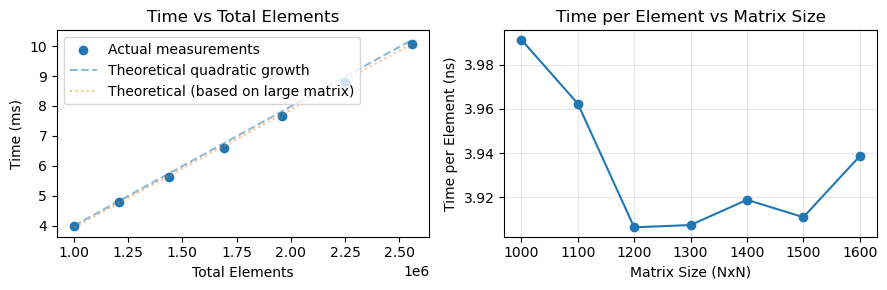

In [129]:
# Visualize the relationships.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

# Plot 1: Time vs Elements with theoretical quadratic growth.
x = results['total_elements']
y = results['avg_time_ms']
ax1.scatter(x, y, label='Actual measurements')
ax1.set_xlabel('Total Elements')
ax1.set_ylabel('Time (ms)')

# Add theoretical quadratic growth line.
theoretical_quad = (x/x.iloc[0]) * y.iloc[0]  # If growth was perfectly quadratic.
ax1.plot(x, theoretical_quad, '--', label='Theoretical quadratic growth', alpha=0.5)

# New theoretical line based on larger matrix timing
large_matrix_time_per_element = results['time_per_element_ns'].iloc[-1] * 1e-6  # convert back to ms
theoretical_large = x * large_matrix_time_per_element
ax1.plot(x, theoretical_large, ':', label='Theoretical (based on large matrix)', alpha=0.5)

ax1.legend(loc='best')
ax1.set_title('Time vs Total Elements')

# Plot 2: Time per element.
ax2.plot(results['size'], results['time_per_element_ns'], 'o-')
ax2.set_xlabel('Matrix Size (NxN)')
ax2.set_ylabel('Time per Element (ns)')
ax2.set_title('Time per Element vs Matrix Size')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Benchmarking Tensor Transfer to GPU

In [46]:
# Warm up the GPU to ensure it's at full clock speed.
# Modern GPUs use dynamic frequency scaling (similar to CPU turbo boost) to save power.
# When idle, they run at lower clock speeds. The first operation might run slower because
# the GPU needs to "wake up" and ramp up to full speed. This is called "cold start" latency.
_size = 10_000
_a = torch.randn(_size, _size).to(device)
_b = torch.randn(_size, _size).to(device)
_ = _a @ _b
torch.cuda.synchronize()

# Clear the cache to prevent unfair caching advantages.
torch.cuda.empty_cache()

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

_size = 50_000
_a = torch.randn(_size, _size).to(device)
_b = torch.randn(_size, _size).to(device)

start.record()
_ = _a @ _b
end.record()

# Wait for GPU operations to complete.
torch.cuda.synchronize()

# Calculate elapsed time in milliseconds.
elapsed_time_ms = start.elapsed_time(end)

print(f'each tensor has {_a.shape[0]:_}x{_a.shape[1]:_} elements')
print(f'took: {elapsed_time_ms:.3f}ms to to a matmul of 2 matrices with {_size*_size:_} elements')

each tensor has 50_000x50_000 elements
took: 7500.901ms to to a matmul of 2 matrices with 2_500_000_000 elements


In [47]:
if _a.is_cuda:
    # Current GPU memory allocated
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1024 / 1024:.2f} MB")
    # Peak GPU memory allocated
    print(f"Peak GPU memory allocated: {torch.cuda.max_memory_allocated() / 1024 / 1024:.2f} MB")

GPU memory allocated: 34734.23 MB
Peak GPU memory allocated: 35116.23 MB


In [49]:
print_tensor_memory(_a)

Memory usage: 9536.74 MB


In [13]:
def benchmark_dot_product(sizes: list[int], num_runs: int=100):
    """
    Benchmark dot product operations for different tensor sizes on CPU and GPU.
    
    Args:
        sizes (list[int]): List of tensor sizes to test
        num_runs (int): Number of times to run each test for averaging
    
    Returns:
        dict: Dictionary containing timing results for CPU and GPU
    """
    results = {
        'cpu_times': [],
        'gpu_times': [],
        'sizes': sizes
    }
        
    for size in sizes:
        # CPU benchmark.
        def cpu_run():
            a = torch.randn(size, size)
            b = torch.randn(size, size)
            # torch.matmul(a, b)
            a @ b
            
        # GPU benchmark.
        def gpu_run():
            a = torch.randn(size, size, device='cuda')
            b = torch.randn(size, size, device='cuda')
            # torch.matmul(a, b)
            a @ b
            torch.cuda.synchronize()  # Ensure GPU operation is complete
            
        # Time the operations
        cpu_time = timeit(cpu_run, number=num_runs) / num_runs
        gpu_time = timeit(gpu_run, number=num_runs) / num_runs
        
        results['cpu_times'].append(cpu_time)
        results['gpu_times'].append(gpu_time)
        
        print(f"Size {size}x{size}:")
        print(f"  CPU: {cpu_time*1000:.2f} ms")
        print(f"  GPU: {gpu_time*1000:.2f} ms")
        print(f"  Speedup: {cpu_time/gpu_time:.2f}x")
        
    return results

In [ ]:
def plot_results(results):
    """
    Create visualization of benchmark results.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot timing comparison
    plt.subplot(1, 2, 1)
    sns.lineplot(x=results['sizes'], y=results['cpu_times'], label='CPU', marker='o')
    sns.lineplot(x=results['sizes'], y=results['gpu_times'], label='GPU', marker='o')
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Time (seconds)')
    plt.title('CPU vs GPU Dot Product Performance')
    plt.grid(True)
    plt.xscale('log')
    plt.yscale('log')
    
    # Plot speedup
    plt.subplot(1, 2, 2)
    speedups = np.array(results['cpu_times']) / np.array(results['gpu_times'])
    sns.lineplot(x=results['sizes'], y=speedups, marker='o', color='green')
    plt.xlabel('Matrix Size (N×N)')
    plt.ylabel('Speedup (CPU time / GPU time)')
    plt.title('GPU Speedup Factor')
    plt.grid(True)
    plt.xscale('log')
    
    plt.tight_layout()
    plt.show()